In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.utils import io
with io.capture_output() as captured:
  !pip install yfinance
  !pip install git+https://github.com/tensorflow/docs
  import tensorflow_docs.modeling
  import sklearn.preprocessing
  import tensorflow as tf
  import os

os.chdir('/content/drive/MyDrive/Colab Notebooks/Crypto')
from data_loader import FinanceFetch
from data_process import DataPreProcess
from models import ModelsHanlder


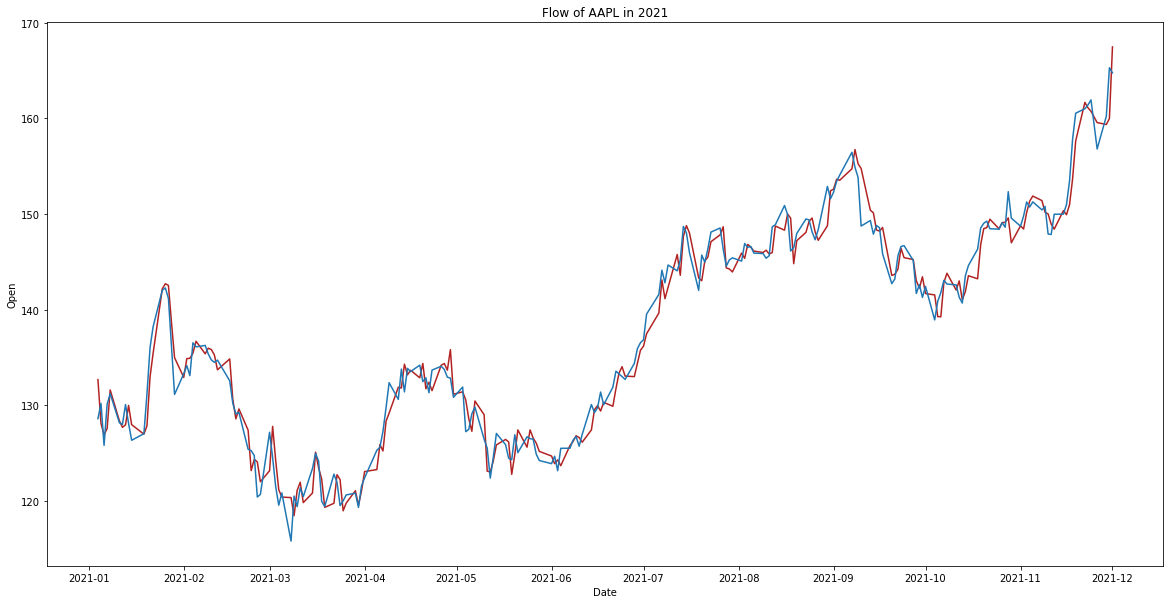

In [58]:
ticket = "AAPL"
TicketHandler = FinanceFetch(ticket)
historical_data = TicketHandler.fetch('max', plot=True, year='2021')

In [59]:
TIMESTEPS = 20

dt = DataPreProcess(scaler=sklearn.preprocessing.StandardScaler, timesteps=TIMESTEPS)
# scale
scaled_data = dt.scale(data=historical_data.loc[:, ['Open','Close','Volume']], 
                       target=historical_data.Close, 
                       timestamp=historical_data.Date)
# train_test
train, test = dt.test(scaled_data, N=100)
# creating windows
X_train, y_train = dt.create_windows(train, col_x=['Open','Close','Volume'], col_y=['Close'])
X_test, y_test= dt.create_windows(test, col_x=['Open','Close','Volume'], col_y=['Close'])

Shape of transormed data: x=(10211, 20, 3), y=(10211, 1)
Shape of transormed data: x=(80, 20, 3), y=(80, 1)


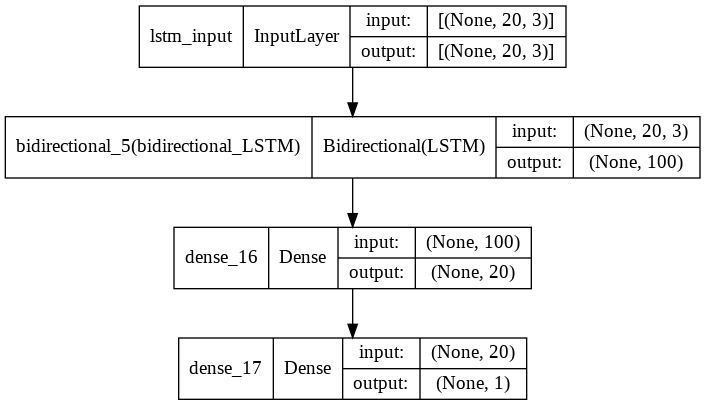

In [64]:
model_handler = ModelsDispatch(batch_size=32)
model = model_handler.bidirectional_LSTM(input_shape=(TIMESTEPS, 3)) 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), 
              loss='mse', 
              metrics=[tf.keras.metrics.MSE, tf.keras.metrics.MAE])

model_handler.draw_model(model, ticket=ticket)

In [65]:
EPOCH = 50
early_stop=tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=50)
history_model = model.fit(x=X_train, 
                          y=y_train, 
                          batch_size=32, 
                          epochs=EPOCH, 
                          shuffle=True, 
                          callbacks=[early_stop, tfdocs.modeling.EpochDots()],
                          validation_split = 0.1)

Epoch 1/50
285/288 [============================>.] - ETA: 0s - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0228
Epoch: 0, loss:0.0022,  mean_absolute_error:0.0227,  mean_squared_error:0.0022,  val_loss:1.7136,  val_mean_absolute_error:0.8569,  val_mean_squared_error:1.7136,  
288/288 [==============================] - 9s 17ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0227 - val_loss: 1.7136 - val_mean_squared_error: 1.7136 - val_mean_absolute_error: 0.8569
Epoch 2/50
288/288 [==============================] - 4s 14ms/step - loss: 2.4848e-04 - mean_squared_error: 2.4848e-04 - mean_absolute_error: 0.0087 - val_loss: 1.5149 - val_mean_squared_error: 1.5149 - val_mean_absolute_error: 0.7772
Epoch 3/50
288/288 [==============================] - 4s 14ms/step - loss: 2.1764e-04 - mean_squared_error: 2.1764e-04 - mean_absolute_error: 0.0077 - val_loss: 1.4570 - val_mean_squared_error: 1.4570 - val_mean_absolute_error: 0.7664
Epoch 4/50
28

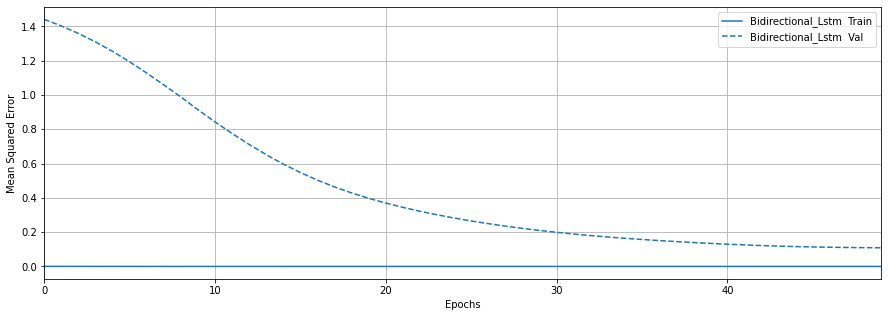

In [67]:
 model_handler.plot_history_model(history_model)

In [68]:
res = model_handler.save_model_and_score(model, X_test, y_test, ticket=ticket, target_scalar=dt.scaler_target)

INFO:tensorflow:Assets written to: ./models//AAPL/bidirectional_LSTM.json/assets


In [22]:
model_handler.load_model(name='Vanilla_LSTM', ticket=ticket)

OSError: ignored